In [21]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [41]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('apple.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

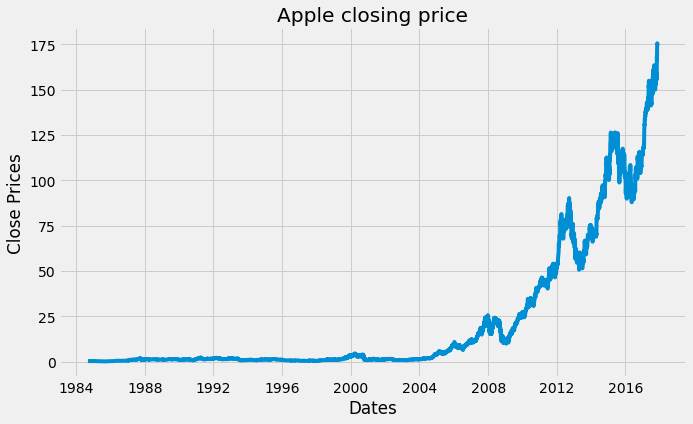

In [59]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Apple closing price')
plt.show()

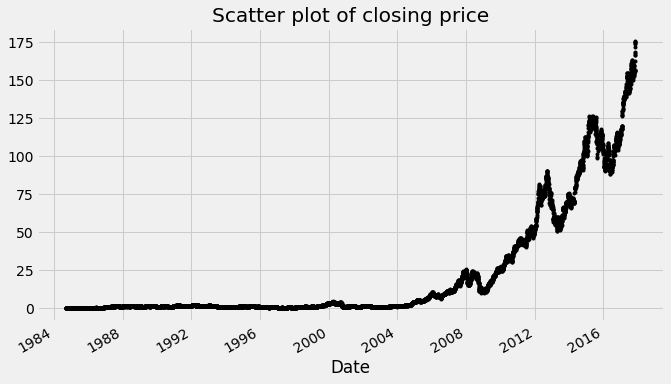

In [43]:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

*ADF (Augmented Dickey-Fuller) Test*

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not.

*Null Hypothesis:* The series has a unit root (value of a =1)

*Alternate Hypothesis:* The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

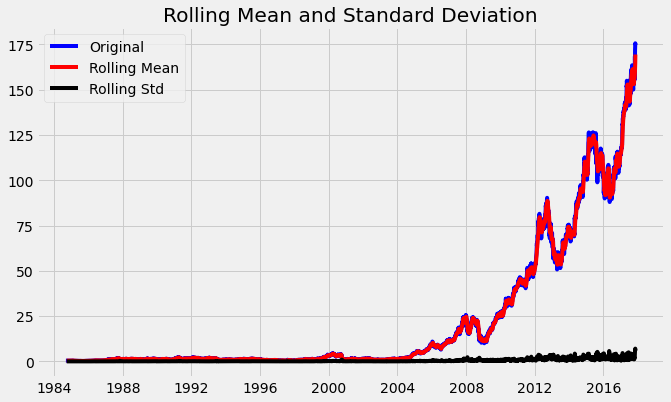

Results of dickey fuller test
Test Statistics                   4.373924
p-value                           1.000000
No. of lags used                 37.000000
Number of observations used    8326.000000
critical value (1%)              -3.431136
critical value (5%)              -2.861887
critical value (10%)             -2.566955
dtype: float64


In [44]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis.<br>
Also, the test statistics is greater than the critical values.<br>
So the data is non-stationary.

<Figure size 720x432 with 0 Axes>

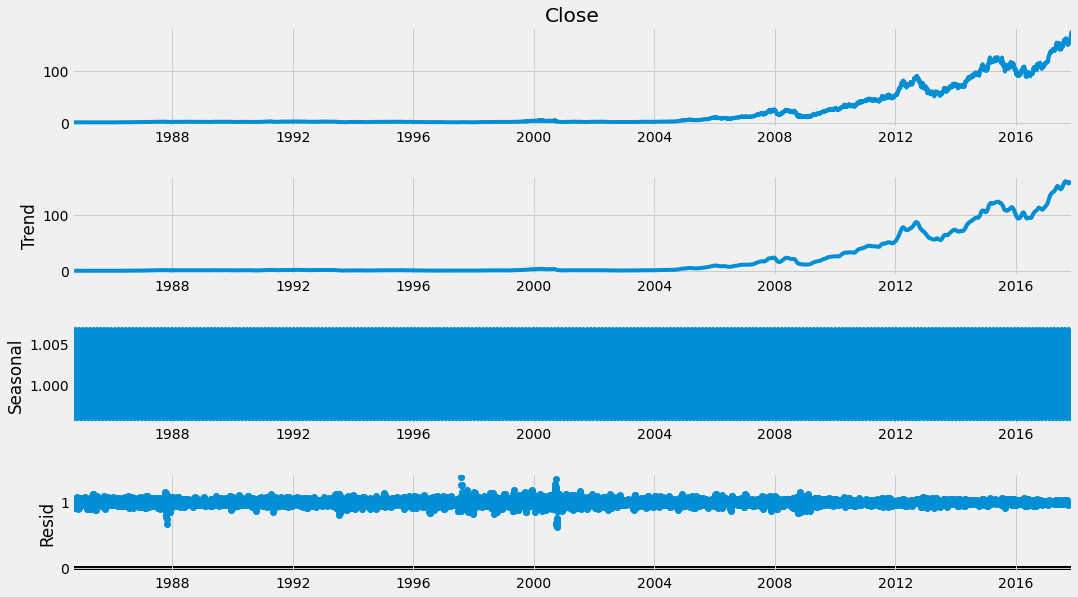

In [45]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


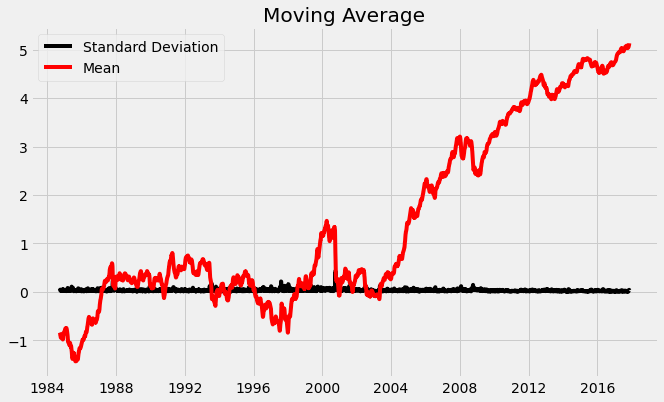

In [46]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

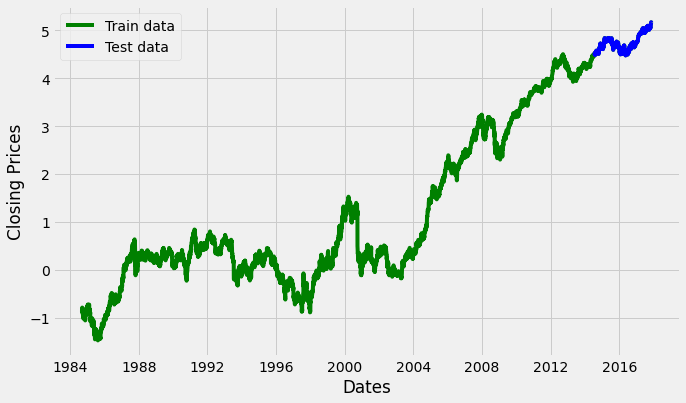

In [47]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [29]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38408.312, Time=0.99 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38411.591, Time=1.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38411.805, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38406.241, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-38408.491, Time=1.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-38413.542, Time=1.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-38411.167, Time=3.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-38420.616, Time=3.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-38423.844, Time=1.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-38421.874, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-38417.218, Time=4.17 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-38421.865, Time=0.94 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 20.707 seconds
                               SARIMAX Results                 

In [30]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38408.312, Time=0.96 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38411.591, Time=1.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38411.805, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38406.241, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-38408.491, Time=1.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-38413.542, Time=1.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-38411.167, Time=3.43 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-38420.616, Time=3.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-38423.844, Time=1.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-38421.874, Time=1.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-38417.218, Time=4.27 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-38421.865, Time=0.94 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0] intercept
Total fit time: 21.210 seconds
                               SARIMAX Results                 

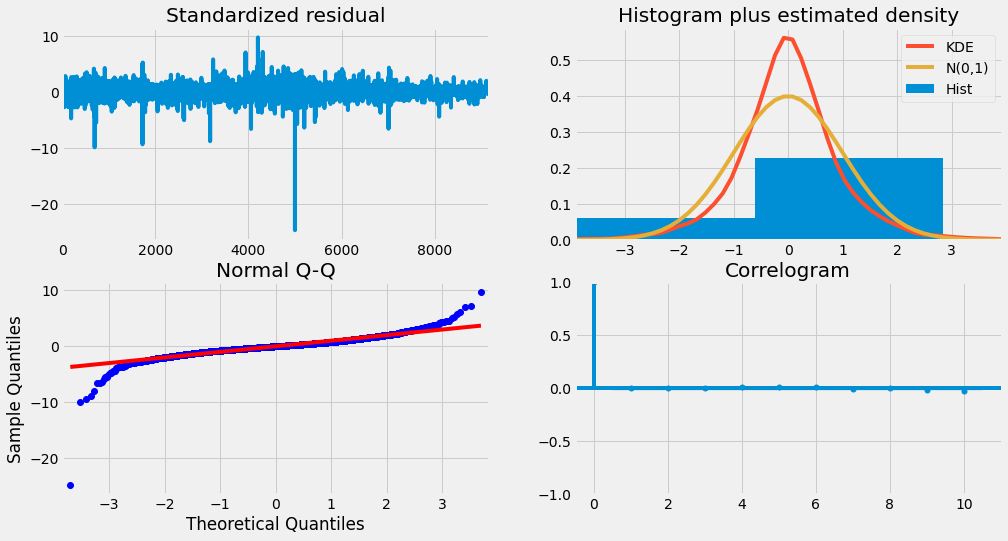

In [31]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [32]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 9171
Model:                 ARIMA(3, 1, 2)   Log Likelihood               19219.115
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 20 May 2021   AIC                         -38424.230
Time:                        19:00:24   BIC                         -38374.364
Sample:                             1   HQIC                        -38407.278
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      2.049      0.041    2.71e-05       0.001
ar.L1.D.Close    -0.6662      0.197     -3.383      0.001      -1.052      -0.280
ar.L2.D.Close    -0.0651      0.169     

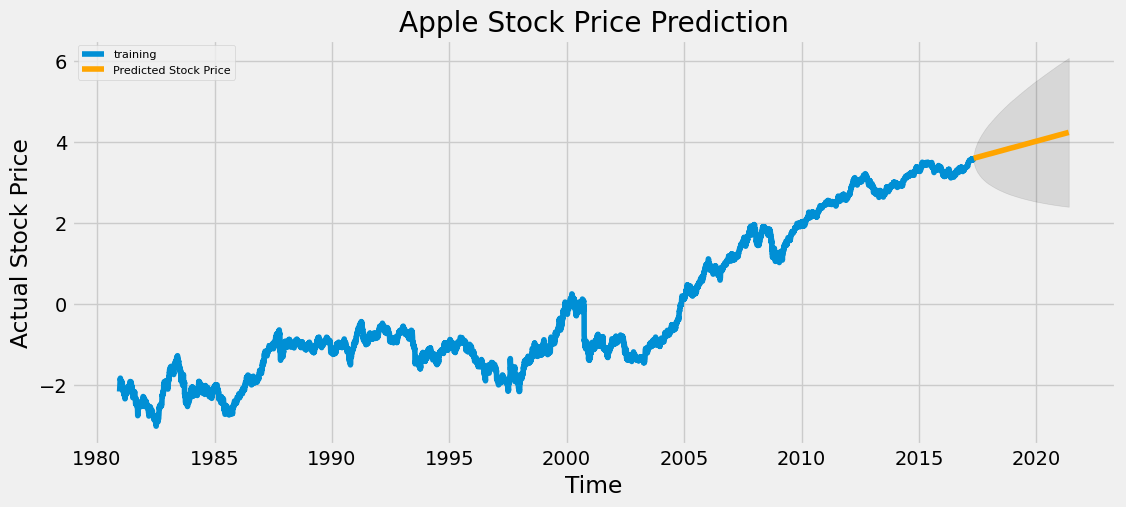

In [38]:
# Forecast
fc, se, conf = fitted.forecast(1020, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
#plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [39]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.1011616940280717
MAE: 0.21903608697146748
RMSE: 0.3180592618177809
MAPE: 0.04886477165067153


In [55]:
accuracy=(1-mape)*100
print(accuracy,"%")

95.11352283493285 %
